In [1]:
import os
from dataclasses import dataclass
from urllib.parse import quote_plus
import nest_asyncio

import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder, TargetEncoder, SumEncoder, QuantileEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from forestci import random_forest_error

from pc_zap_scrapper.v2.database import DatabaseHandler, TableRealEstateInfo

In [2]:
from tqdm import tqdm

In [3]:

nest_asyncio.apply()

sklearn.set_config(transform_output="pandas")

pd.options.display.max_columns = None

# Functions

In [3]:
def grouped_train_test_split(df: pd.DataFrame, groups: pd.Series, test_size: float, random_state: float | None = None):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)    
    train_idx, test_idx = next(gss.split(df, groups=groups))
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)
    return df_train, df_test

def set_k_train_folds(df_train, index_column, target_column, n_folds):
    folds = [Fold(df_train, train_index, val_index) for train_index, val_index in GroupKFold(n_splits=n_folds).split(df_train, groups=df_train[index_column])]
    return folds

@dataclass
class Fold:
    data_train: pd.DataFrame
    data_val: pd.DataFrame

    def __init__(self, df, train_index, val_index):
        self.data_train = df.iloc[train_index]
        self.data_val = df.iloc[val_index]


In [4]:

def predict_interval(X, pipeline, quantile = [0.25, 0.5, 0.75]):
    all_tree_predictions = pd.DataFrame([tree.predict(X.values) for tree in pipeline.named_steps['regressor'].estimators_])
    response = all_tree_predictions.quantile(quantile).T
    response.columns = ["lower", "median", "upper"]
    return response


In [5]:


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")
        return X[self.columns].copy()


class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column  # Nome da coluna de data

    def fit(self, X, y=None):
        # Nenhum ajuste necessário
        return self

    def transform(self, X):
        X = X.copy()
        # Converte a coluna de data para datetime se não estiver
        if not np.issubdtype(X[self.date_column].dtype, np.datetime64):
            X[self.date_column] = pd.to_datetime(X[self.date_column], errors='coerce')
        
        # Verifica se houve erro na conversão
        if X[self.date_column].isnull().any():
            raise ValueError("Há valores nulos ou formatos inválidos na coluna de data após a conversão.")
        
        # Extrai ano, mês, dia e número da semana
        X['year'] = X[self.date_column].dt.year
        X['month'] = X[self.date_column].dt.month
        X['day'] = X[self.date_column].dt.day
        X['week_number'] = X[self.date_column].dt.isocalendar().week

        # Remove a coluna original de data (opcional)
        X = X.drop(columns=[self.date_column])

        return X

class AmenitiesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, amenities_column='amenities_list', relevant_amenities=None):
        self.amenities_column = amenities_column
        self.relevant_amenities = relevant_amenities

    def fit(self, X, y=None):
        # Nenhum ajuste necessário, mas você pode implementar se quiser
        return self

    def transform(self, X):
        import numpy as np
        import pandas as pd
        import ast

        X = X.copy()
        relevant_amenities = np.array(self.relevant_amenities)

        def crate_amenities_encoding(x):
            if not x or pd.isna(x):
                return np.zeros(len(relevant_amenities), dtype=int)
            try:
                estate_amenities = ast.literal_eval(x)
                return np.isin(relevant_amenities, estate_amenities).astype(int)
            except (ValueError, SyntaxError):
                return np.zeros(len(relevant_amenities), dtype=int)

        amenities_encoded_list = X[self.amenities_column].apply(crate_amenities_encoding).tolist()
        amenities_encoded = pd.DataFrame(amenities_encoded_list, columns=relevant_amenities)

        # Concatenar as novas colunas ao DataFrame original
        X.reset_index(drop=True, inplace=True)
        amenities_encoded.reset_index(drop=True, inplace=True)
        X = pd.concat([X, amenities_encoded], axis=1)

        # Remover a coluna original de amenidades, se desejar
        X.drop(columns=[self.amenities_column], inplace=True)

        return X



class Discretizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_bins=5, encode='ordinal', strategy='quantile'):
        self.columns = columns
        self.n_bins = n_bins
        self.encode = encode
        self.strategy = strategy
        self.discretizer_ = None

    def fit(self, X, y=None):
        # Verificar se todas as colunas existem no DataFrame
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")

        # Ajustar o discretizador apenas com as colunas selecionadas
        self.discretizer_ = KBinsDiscretizer(n_bins=self.n_bins, encode=self.encode, strategy=self.strategy)
        self.discretizer_.fit(X[self.columns])

        return self

    def transform(self, X):
        X = X.copy()
        # Verificar novamente se todas as colunas estão presentes
        missing_cols = [col for col in self.columns if col not in X.columns]
        if missing_cols:
            raise ValueError(f"As seguintes colunas estão faltando no DataFrame: {missing_cols}")

        # Aplicar o discretizador às colunas
        transformed_values = self.discretizer_.transform(X[self.columns])
        
        # Se o encode for 'ordinal', a saída é um array 2D com os buckets, substituímos diretamente
        # Se for 'onehot' ou 'onehot-dense', teremos mais colunas do que inicialmente
        # Nesse caso, é necessário criar novas colunas. Aqui vamos lidar apenas com 'ordinal' para simplificar.
        if self.encode == 'ordinal':
            X[self.columns] = transformed_values
        else:
            # Caso onehot, criamos um DataFrame separado e concatenamos
            # Os nomes das colunas podem ser gerados a partir das colunas originais + índices dos bins
            bin_column_names = []
            for col_idx, col_name in enumerate(self.columns):
                for bin_idx in range(self.n_bins):
                    bin_column_names.append(f"{col_name}_bin_{bin_idx}")
            
            onehot_df = pd.DataFrame(transformed_values, columns=bin_column_names, index=X.index)
            # Remover as colunas originais e concatenar as novas
            X.drop(columns=self.columns, inplace=True)
            X = pd.concat([X, onehot_df], axis=1)

        return X


# Getting Data

In [6]:

db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)

sql_query = """
SELECT * FROM real_estate_info
"""

data_raw = await db_handler.query(sql_query)

await db_handler.close()


# Data Cleaning

In [154]:
data = data_raw.copy()
data = data.loc[~data["price"].isna()]
data = data.loc[data["price"] > 0]
data["price"] = data["price"].astype(float)

data = data[data["price"] < 6_000_000]

data["link"] = data["link"].where(data["link"].str[:29]=="https://www.zapimoveis.com.br", "https://www.zapimoveis.com.br" +  data["link"])

INFERED_TYPES = [
    'apartamento', 'casa', 'terreno', 'fazenda', 'loja', 'sobrados',
    'galpao', 'conjunto', 'cobertura', 'studio', 'flat', 'quitinete',
    'chacara',
]


data["infered_type"] = data["link"]
data["infered_type"] = np.where(data["infered_type"].str[:30]=="https://www.zapimoveis.com.br/", data["infered_type"].str.replace("https://www.zapimoveis.com.br", ""), data["infered_type"])
data["infered_type"] = np.where(data["infered_type"].str[:11] == "/lancamento", data["infered_type"].str.replace("/lancamento", ""), data["infered_type"])
data["infered_type"] = data["infered_type"].str.replace("/imovel", "")
data["infered_type"] = data["infered_type"].str.replace("/venda", "")
data["infered_type"] = np.where(data["infered_type"].str[:1] == "-", data["infered_type"].str[1:], data["infered_type"])
data["infered_type"] = data["infered_type"].str.split("-").str[0]
data["infered_type"] = data["infered_type"].where(data["infered_type"].isin(INFERED_TYPES), "outro")

casas = data.loc[data["infered_type"] == "casa"]
casas.loc[casas["floor_size"] > 10000, "floor_size"] = np.nan
casas = casas.loc[casas["floor_size"] < 1100]

casas["number_of_rooms"] = casas["number_of_rooms"].clip(1,10)
casas["number_of_bathrooms"] = casas["number_of_bathrooms"].clip(1,6)
casas["number_of_parking_spaces"] = casas["number_of_parking_spaces"].clip(0,6)

# teste
casas = casas.loc[casas["price"] <= 2_500_000]

# Splitting

In [156]:
# Não podemos usar o index do dataframe. Esse é o index no imóvel,
# que pode aparecer mais de uma vez no dataframe
INDEX_COLUMN = 'estate_id'
N_FOLDS = 5
TARGET_COLUMN = 'price'
TEST_SIZE = 0.2

data_train_full, data_test = grouped_train_test_split(casas, groups=casas[INDEX_COLUMN], test_size=TEST_SIZE, random_state=42)


data_train, data_cal = grouped_train_test_split(data_train_full, groups=data_train_full[INDEX_COLUMN], test_size=TEST_SIZE, random_state=42)


train_folds = set_k_train_folds(data_train, index_column=INDEX_COLUMN, target_column=TARGET_COLUMN, n_folds=N_FOLDS)

In [20]:
# casas

# Experimentos

In [157]:
import seaborn as sns

regplot_opts = dict(
    line_kws={"color": "red", "linewidth": 2},
    scatter_kws={"alpha": 0.01, "edgecolor": "none"},
)


<Axes: xlabel='floor_size', ylabel='price'>

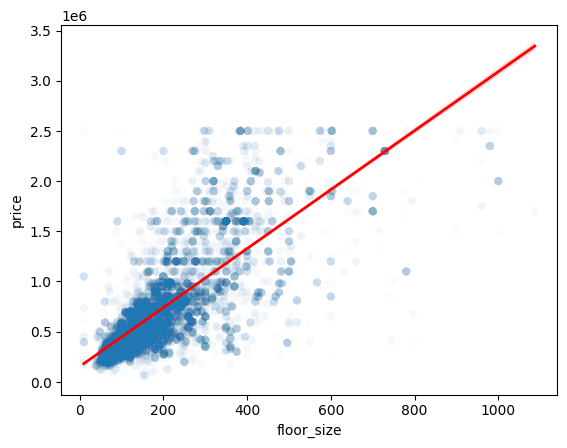

In [158]:

sns.regplot(data=casas, x="floor_size", y="price", **regplot_opts)

<Axes: xlabel='number_of_rooms', ylabel='price'>

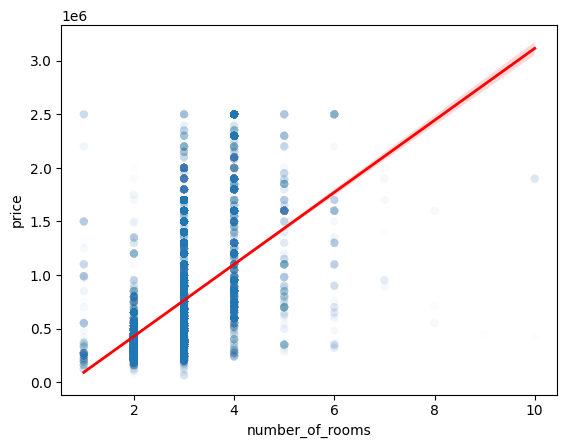

In [159]:
sns.regplot(data=casas, x="number_of_rooms", y="price", **regplot_opts)

<Axes: xlabel='number_of_bathrooms', ylabel='price'>

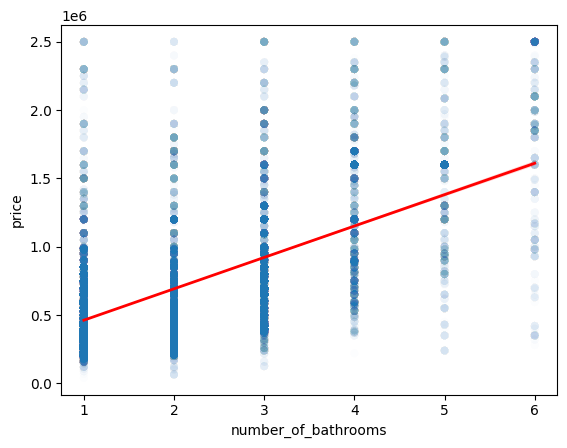

In [160]:
sns.regplot(data=casas, x="number_of_bathrooms", y="price", **regplot_opts)

<Axes: xlabel='number_of_parking_spaces', ylabel='price'>

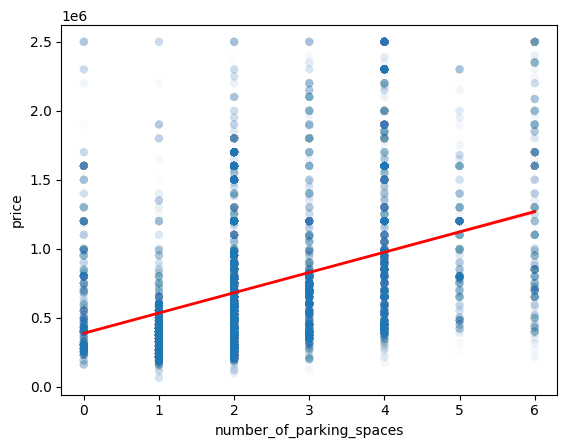

In [161]:
sns.regplot(data=casas, x="number_of_parking_spaces", y="price", **regplot_opts)

# Experimentos

In [162]:
%%time

selected_columns = [
    'search_date',
    'infered_type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]

categorical_columns = [
    "infered_type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]

numerical_columns = [
    "latitude",
    "longitude",
    "floor_size",
    "condominium",
    "iptu",

]

# best_params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': True} # 119804.3701218476,
# best_params = {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
best_params = {}



pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    # ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),  # MAE=94k
    ('imputation', KNNImputer(n_neighbors=10)),  # MAE=94k
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42, **best_params))
])

TARGET_COLUMN = "price"

X_train = data_train.drop(columns=TARGET_COLUMN)
X_test = data_test.drop(columns=TARGET_COLUMN)

y_train = data_train[TARGET_COLUMN]
y_test = data_test[TARGET_COLUMN]

median_price = y_train.median()
weights = 1+np.log1p(np.abs(y_train-median_price) / median_price)

pipeline.fit(X_train, y_train, regressor__sample_weight=weights)

y_train_predicted = pipeline.predict(X_train)
y_test_predicted = pipeline.predict(X_test)

print(
    {
        # "mae_train": mean_absolute_error(y_train, y_train_predicted),
        # "r2_train": r2_score(y_train, y_train_predicted),
        "mae_val": mean_absolute_error(y_test, y_test_predicted),
        "r2_val": r2_score(y_test, y_test_predicted),
    }
)


# preprocessing_pipeline = Pipeline(pipeline.steps[:-1])
# regressor = pipeline.steps[-1]


# X_test_transf = preprocessing_pipeline.transform(X_test)
# test_confidence_interval = predict_interval(X_test_transf, pipeline)

# print(
#     "Estimates with median:",
#     {
#         "mae_val": mean_absolute_error(y_test, test_confidence_interval["median"]),
#         "r2_val": r2_score(y_test, test_confidence_interval["median"]),
#     }
# )

{'mae_val': np.float64(145607.1511497205), 'r2_val': 0.7716174692383309}
CPU times: user 35.8 s, sys: 9.07 s, total: 44.9 s
Wall time: 23.3 s


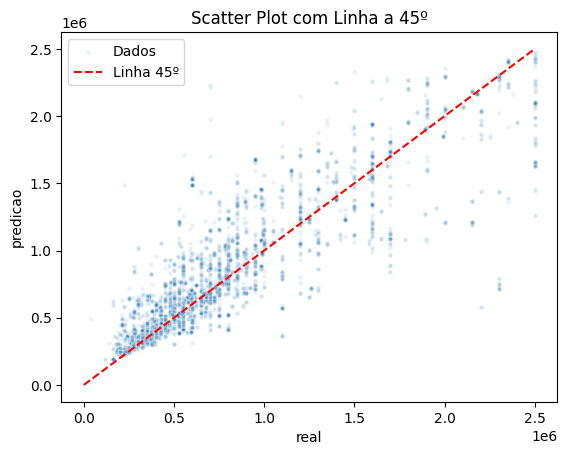

In [178]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemplo de DataFrame
df = y_test_predictions

fig, ax = plt.subplots()

# Plot do scatter
ax.scatter(y_test, y_test_predicted, label='Dados', alpha=0.1, edgecolor="#ffffffff", marker=".")

# Determina o alcance máximo do gráfico para a linha
max_val = max(y_test.max(), y_test_predicted.max())
min_val = min(y_test.min(), y_test_predicted.min())

# Cria uma linha y = x (45 graus) passando pela origem
ax.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Linha 45º')

# Configurações opcionais de título e rótulos
ax.set_title('Scatter Plot com Linha a 45º')
ax.set_xlabel('real')
ax.set_ylabel('predicao')
ax.legend()

plt.show()


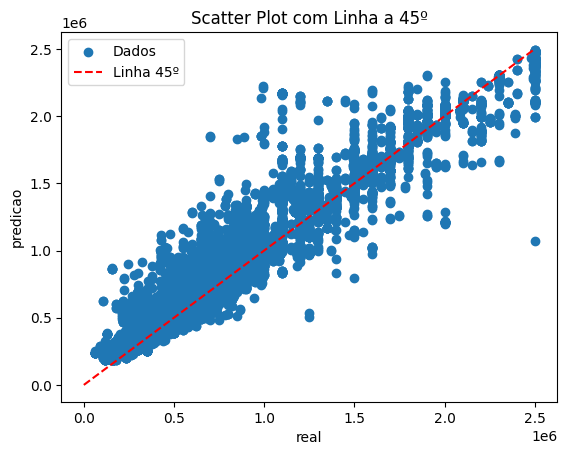

In [164]:
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

# Plot do scatter
ax.scatter(y_train, y_train_predicted, label='Dados')

# Determina o alcance máximo do gráfico para a linha
max_val = max(y_train.max(), y_train_predicted.max())
min_val = min(y_train.min(), y_train_predicted.min())

# Cria uma linha y = x (45 graus) passando pela origem
ax.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Linha 45º')

# Configurações opcionais de título e rótulos
ax.set_title('Scatter Plot com Linha a 45º')
ax.set_xlabel('real')
ax.set_ylabel('predicao')
ax.legend()

plt.show()


# Preço por metro quadrado

In [147]:
2.5e6

2500000.0

In [133]:
%%time

selected_columns = [
    'search_date',
    'infered_type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]

categorical_columns = [
    "infered_type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]

numerical_columns = [
    "latitude",
    "longitude",
    "floor_size",
    "condominium",
    "iptu",

]

# best_params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': True} # 119804.3701218476,
# best_params = {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
best_params = {}



pipeline = Pipeline([
    ('filter_columns', ColumnSelector(columns=selected_columns)),
    ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
    ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='mean')),  # MAE=94k
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42, **best_params))
])

TARGET_COLUMN = "price_m2"

data_train["price_m2"] = data_train["price"]/ data_train["floor_size"]
data_test["price_m2"] = data_test["price"]/ data_test["floor_size"]

X_train = data_train.drop(columns=TARGET_COLUMN)
X_test = data_test.drop(columns=TARGET_COLUMN)

y_train = data_train[TARGET_COLUMN]
y_test = data_test[TARGET_COLUMN]

pipeline.fit(X_train, y_train)

y_train_predicted = pipeline.predict(X_train)
y_test_predicted = pipeline.predict(X_test)

print(
    {
        # "mae_train": mean_absolute_error(y_train, y_train_predicted),
        # "r2_train": r2_score(y_train, y_train_predicted),
        "mae_val": mean_absolute_error(y_test, y_test_predicted),
        "r2_val": r2_score(y_test, y_test_predicted),
    }
)


# preprocessing_pipeline = Pipeline(pipeline.steps[:-1])
# regressor = pipeline.steps[-1]


# X_test_transf = preprocessing_pipeline.transform(X_test)
# test_confidence_interval = predict_interval(X_test_transf, pipeline)

# print(
#     "Estimates with median:",
#     {
#         "mae_val": mean_absolute_error(y_test, test_confidence_interval["median"]),
#         "r2_val": r2_score(y_test, test_confidence_interval["median"]),
#     }
# )

{'mae_val': np.float64(980.2436364063195), 'r2_val': 0.7370267094666139}
CPU times: user 16.4 s, sys: 19.3 ms, total: 16.4 s
Wall time: 16.4 s


In [142]:
price_test_predicted = y_test_predicted * X_test["floor_size"]
price_test = data_test["price"]

print(
    {
        # "mae_train": mean_absolute_error(y_train, y_train_predicted),
        # "r2_train": r2_score(y_train, y_train_predicted),
        "mae_val": mean_absolute_error(price_test, price_test_predicted),
        "r2_val": r2_score(price_test, price_test_predicted),
    }
)


{'mae_val': np.float64(187642.55538094646), 'r2_val': 0.7382828843325068}


In [137]:
234.0 * 4086.17720766

956165.46659244

# Bootstrap

In [88]:
%%time

selected_columns = [
    'search_date',
    'infered_type',
    'neighbor',
    'latitude',
    'longitude',
    'floor_size',
    'number_of_rooms',
    'number_of_bathrooms',
    'number_of_parking_spaces',
    'condominium',
    'iptu',
]

categorical_columns = [
    "infered_type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]

numerical_columns = [
    "latitude",
    "longitude",
    "floor_size",
    "condominium",
    "iptu",

]

# best_params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'bootstrap': True} # 119804.3701218476,
# best_params = {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'bootstrap': False}
best_params = {}


pipelines = []



for i in tqdm(range(100)):

    pipeline = Pipeline([
        ('filter_columns', ColumnSelector(columns=selected_columns)),
        ('extrai_atributos_data', DateFeatureExtractor(date_column='search_date')),
        ('category_encoders', CatBoostEncoder(cols=categorical_columns)),
        # ('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),  # MAE=94k
        ('imputation', KNNImputer(n_neighbors=10)),  # MAE=94k
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=None, **best_params))
    ])
    
    data_train_sample = data_train.sample(n=10000, replace=True, random_state=None)
    X_train = data_train_sample.drop(columns=TARGET_COLUMN)
    y_train = data_train_sample[TARGET_COLUMN]
    pipeline.fit(X_train, y_train)
    pipelines.append(pipeline)
    
    # X_test = data_test.drop(columns=TARGET_COLUMN)
    
    # y_test = data_test[TARGET_COLUMN]
    
    
# y_train_predicted = pipeline.predict(X_train)
# y_test_predicted = pipeline.predict(X_test)

# print(
#     {
#         # "mae_train": mean_absolute_error(y_train, y_train_predicted),
#         # "r2_train": r2_score(y_train, y_train_predicted),
#         "mae_val": mean_absolute_error(y_test, y_test_predicted),
#         "r2_val": r2_score(y_test, y_test_predicted),
#     }
# )


100%|██████████| 100/100 [10:26<00:00,  6.26s/it]

CPU times: user 14min 30s, sys: 1min 39s, total: 16min 10s
Wall time: 10min 26s


In [121]:
median_price = data_train_sample["price"].median()
weights = 1+np.log1p(np.abs(data_train_sample["price"]-median_price) / median_price)

weights.max()

np.float64(2.9475782061560105)

In [124]:
pipeline.fit(X_train, y_train, regressor__sample_weight=weights)

Pipeline(steps=[('filter_columns',
                 ColumnSelector(columns=['search_date', 'infered_type',
                                         'neighbor', 'latitude', 'longitude',
                                         'floor_size', 'number_of_rooms',
                                         'number_of_bathrooms',
                                         'number_of_parking_spaces',
                                         'condominium', 'iptu'])),
                ('extrai_atributos_data',
                 DateFeatureExtractor(date_column='search_date')),
                ('category_encoders',
                 CatBoostEncoder(cols=['infered_type', 'neighbor',
                                       'number_of_rooms', 'number_of_bathrooms',
                                       'number_of_parking_spaces'])),
                ('imputation', KNNImputer(n_neighbors=10)),
                ('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [ ]:
regressor__sample_weight=sample_weights

In [96]:
X_test = data_test.drop(columns=TARGET_COLUMN)

y_test = data_test[TARGET_COLUMN]


y_test_all_predictions = pd.DataFrame([pipe.predict(X_test) for pipe in tqdm(pipelines)]).T
y_test_predictions = y_test_all_predictions.quantile([0.15865, 0.5, 0.84135], axis=1).T

100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


In [104]:
y_test_predictions["real"] = y_test

y_test_predictions

,0.15865,0.5,0.84135,real
0,8.664539e+05,965709.995,1.038442e+06,950000.0
1,5.614151e+05,599332.935,6.261975e+05,370000.0
2,1.173754e+06,1242321.650,1.326829e+06,750000.0
3,4.808255e+05,518614.995,5.603019e+05,590000.0
4,3.320571e+05,361917.000,3.885467e+05,447982.0
...,...,...,...,...
6619,8.510603e+05,963265.750,1.050761e+06,1300000.0
6620,3.127208e+06,3379382.600,3.729906e+06,4900000.0
6621,1.495878e+06,1683015.895,1.790406e+06,1800000.0
6622,1.573949e+06,1609994.925,1.645456e+06,1650000.0


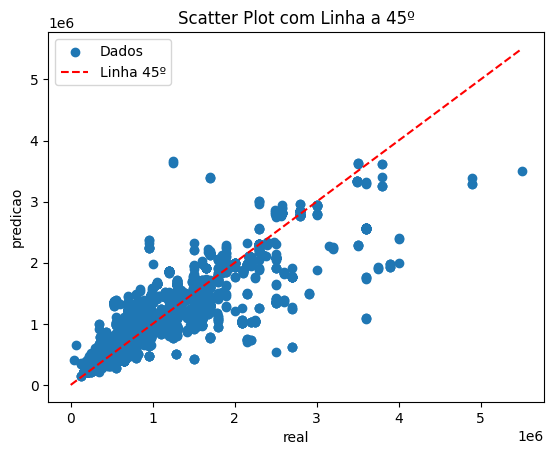

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemplo de DataFrame
df = y_test_predictions

fig, ax = plt.subplots()

# Plot do scatter
ax.scatter(df['real'], df[0.5], label='Dados')

# Determina o alcance máximo do gráfico para a linha
max_val = max(df['real'].max(), df[0.5].max())
min_val = min(df['real'].min(), df[0.5].min())

# Cria uma linha y = x (45 graus) passando pela origem
ax.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Linha 45º')

# Configurações opcionais de título e rótulos
ax.set_title('Scatter Plot com Linha a 45º')
ax.set_xlabel('real')
ax.set_ylabel('predicao')
ax.legend()

plt.show()


In [98]:
y_test_all_predictions = y_test_all_predictions.T

In [92]:


y_test_predictions

,0.15865,0.5,0.84135,real
0,8.664539e+05,965709.995,1.038442e+06,950000.0
1,5.614151e+05,599332.935,6.261975e+05,370000.0
2,1.173754e+06,1242321.650,1.326829e+06,750000.0
3,4.808255e+05,518614.995,5.603019e+05,590000.0
4,3.320571e+05,361917.000,3.885467e+05,447982.0
...,...,...,...,...
6619,8.510603e+05,963265.750,1.050761e+06,1300000.0
6620,3.127208e+06,3379382.600,3.729906e+06,4900000.0
6621,1.495878e+06,1683015.895,1.790406e+06,1800000.0
6622,1.573949e+06,1609994.925,1.645456e+06,1650000.0


In [95]:
print(
    {
        "mae_val": mean_absolute_error(y_test, y_test_predictions[0.5]),
        "r2_val": r2_score(y_test, y_test_predictions[0.5]),
    }
)

{'mae_val': np.float64(140169.01628321255), 'r2_val': 0.8134744408641992}


In [68]:
y_test_predictions.shape

(6624, 100)

In [73]:
y_test_predictions.quantile([0.15865, 0.5, 0.84135], axis=1).T

,0.15865,0.50000,0.84135
0,6.557427e+05,771704.970,8.714953e+05
1,4.826881e+05,560430.645,6.227259e+05
2,1.059988e+06,1178505.990,1.321280e+06
3,4.215879e+05,471375.570,5.299015e+05
4,3.294935e+05,351896.755,3.794072e+05
...,...,...,...
6619,7.880385e+05,904934.995,1.042329e+06
6620,2.821513e+06,3063300.000,3.391860e+06
6621,1.226654e+06,1467250.165,1.636500e+06
6622,1.558130e+06,1662150.400,1.770500e+06


In [56]:


pipelines[1].predict(X_train.iloc[:1])

array([708399.79])

In [60]:
pd.DataFrame(temp).median()

0       651894.915
1       497414.500
2       656830.000
3       373433.250
4       891202.940
          ...     
995     601779.530
996     775219.575
997     809249.000
998     385971.950
999    1014550.000
Length: 1000, dtype: float64

In [27]:
X_cal = data_cal.drop(columns=TARGET_COLUMN)
y_cal = data_cal[TARGET_COLUMN]
y_cal_pred = pipeline.predict(X_cal)
residuals = np.abs(y_cal - y_cal_pred)

In [29]:
# 5. Calcular o quantil desejado dos resíduos
alpha = 1 - confidence_level
quantile = np.quantile(residuals, 1 - alpha)

# 6. Prever no conjunto de teste
y_test_pred = pipeline.predict(X_test)

# Construir intervalos de predição
y_lower = y_test_pred - quantile
y_upper = y_test_pred + quantile

In [ ]:
def predict_inderval(X, pipeline, residuals, confidence_level=0.95):
    alpha = 1 - confidence_level
    quantile = np.quantile(residuals, 1 - alpha)
    y_pred = pipeline.predict(X)
    y_lower = y_pred - quantile
    y_upper = y_pred + quantile
    return pd.Data

In [37]:
pd.DataFrame({"prediction": y_test_pred, "lower": y_lower, "upper": y_upper})

,prediction,lower,upper
0,944600.00,373424.00,1515776.00
1,641179.99,70003.99,1212355.99
2,1069862.40,498686.40,1641038.40
3,602149.99,30973.99,1173325.99
4,319009.00,-252167.00,890185.00
...,...,...,...
6619,1222694.10,651518.10,1793870.10
6620,3418896.00,2847720.00,3990072.00
6621,1754281.40,1183105.40,2325457.40
6622,1717359.79,1146183.79,2288535.79


In [33]:
y_test_pred

array([ 944600.  ,  641179.99, 1069862.4 , ..., 1754281.4 , 1717359.79,
       2113824.99])

In [34]:
y_lower

array([ 373424.  ,   70003.99,  498686.4 , ..., 1183105.4 , 1146183.79,
       1542648.99])

In [35]:
y_upper

array([1515776.  , 1212355.99, 1641038.4 , ..., 2325457.4 , 2288535.79,
       2685000.99])

In [32]:
# Mostrar alguns resultados
for i in range(5):
    print(f"X_test={X_test[i][0]:.2f}, Prediction={y_test_pred[i]:.2f}, Interval=[{y_lower[i]:.2f}, {y_upper[i]:.2f}], True_y={y_test[i]:.2f}")


KeyError: 0

In [151]:
# X_test

In [193]:

def predict_interval(X, pipeline, quantile = [0.15865, 0.5, 0.84135]):
    preprocessing_pipeline = Pipeline(pipeline.steps[:-1])
    X_transf = preprocessing_pipeline.transform(X)
    all_tree_predictions = pd.DataFrame([tree.predict(X_transf.values) for tree in pipeline.named_steps['regressor'].estimators_]).T
    response = all_tree_predictions.quantile(quantile, axis=1).T
    response.columns = ["lower", "median", "upper"]
    return response



preprocessing_pipeline = Pipeline(pipeline.steps[:-1])
regressor = pipeline.steps[-1]


test_confidence_interval = predict_interval(X_test, pipeline)

# print(
#     "Estimates with median:",
#     {
#         "mae_val": mean_absolute_error(y_test, test_confidence_interval["median"]),
#         "r2_val": r2_score(y_test, test_confidence_interval["median"]),
#     }
# )

In [196]:
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt

# # Configurações
# np.random.seed(42)
# confidence_level = 0.95

# # 1. Gerar dados sintéticos
# # Vamos criar dados a partir de uma função y = 2x + ruído
# X = np.linspace(0, 10, 200)
# y = 2 * X + np.random.normal(0, 1, size=X.shape[0])
# X = X.reshape(-1, 1)

# # 2. Dividir dados em treino, calibração e teste
# # Primeiro dividimos em treino e restante
# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Depois dividimos o conjunto de treino completo em treino e calibração
# X_train, X_cal, y_train, y_cal = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# # 3. Treinar o modelo no conjunto de treino
# model = LinearRegression()
# model.fit(X_train, y_train)

# # 4. Prever no conjunto de calibração e obter os resíduos absolutos
# y_cal_pred = model.predict(X_cal)
# residuals = np.abs(y_cal - y_cal_pred)

# # 5. Calcular o quantil desejado dos resíduos
# alpha = 1 - confidence_level
# quantile = np.quantile(residuals, 1 - alpha)

# # 6. Prever no conjunto de teste
# y_test_pred = model.predict(X_test)

# # Construir intervalos de predição
# y_lower = y_test_pred - quantile
# y_upper = y_test_pred + quantile

# # Mostrar alguns resultados
# for i in range(5):
#     print(f"X_test={X_test[i][0]:.2f}, Prediction={y_test_pred[i]:.2f}, Interval=[{y_lower[i]:.2f}, {y_upper[i]:.2f}], True_y={y_test[i]:.2f}")

# # Plot para visualizar
# plt.figure(figsize=(8,6))
# plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Train Data')
# plt.scatter(X_cal, y_cal, color='green', alpha=0.5, label='Calibration Data')
# plt.scatter(X_test, y_test, color='red', alpha=0.7, label='Test Data')
# plt.plot(X_test, y_test_pred, color='black', label='Prediction')
# plt.fill_between(X_test.ravel(), y_lower, y_upper, color='gray', alpha=0.3, label='Conformal Interval')
# plt.legend()
# plt.xlabel("X")
# plt.ylabel("y")
# plt.title("Conformal Prediction Intervals")
# plt.show()


In [194]:
test_confidence_interval

,lower,median,upper
0,480000.0,580000.0,950000.00
1,450000.0,650000.0,692936.50
2,750000.0,1190000.0,1499293.65
3,450000.0,595000.0,1370000.00
4,230000.0,360000.0,580000.00
...,...,...,...
6619,700000.0,900000.0,1523492.00
6620,3000000.0,4050000.0,4800000.00
6621,1800000.0,1800000.0,1800000.00
6622,1550000.0,1550000.0,1600000.00


In [186]:
test_confidence_interval

,lower,median,upper
0,580000.00,580000.0,842500.0
1,475190.25,650000.0,680000.0
2,800000.00,1190000.0,1262500.0
3,537499.25,595000.0,700000.0
4,230000.00,360000.0,580000.0
...,...,...,...
6619,750000.00,900000.0,1300000.0
6620,3200000.00,4050000.0,4800000.0
6621,1800000.00,1800000.0,1800000.0
6622,1550000.00,1550000.0,1600000.0


In [176]:
preprocessing_pipeline = Pipeline(pipeline.steps[:-1])
X_test_transf = preprocessing_pipeline.transform(X_test)
all_tree_predictions = pd.DataFrame([tree.predict(X_test_transf.values) for tree in pipeline.named_steps['regressor'].estimators_]).T

In [171]:
all_tree_predictions.iloc[:1].quantile([0.25,0.5,0.75], axis=1).T

,0.25,0.50,0.75
0,415000.0,600000.0,1100000.0


In [183]:
all_tree_predictions.iloc[0:1].quantile(0.15, axis=1)

0    480000.0
Name: 0.15, dtype: float64

In [184]:
all_tree_predictions.iloc[0:1].mean(axis=1)

0    738130.0
dtype: float64

In [168]:
all_tree_predictions.iloc[:1].mean(axis=1)

0    842486.847071
dtype: float64

In [169]:
test_confidence_interval

,lower,median,upper
0,580000.00,580000.0,842500.0
1,475190.25,650000.0,680000.0
2,800000.00,1190000.0,1262500.0
3,537499.25,595000.0,700000.0
4,230000.00,360000.0,580000.0
...,...,...,...
6619,750000.00,900000.0,1300000.0
6620,3200000.00,4050000.0,4800000.0
6621,1800000.00,1800000.0,1800000.0
6622,1550000.00,1550000.0,1600000.0


In [144]:
len(pipeline.named_steps['regressor'].estimators_)

100

In [66]:
data_train[data_train["floor_size"] > 100_000]

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,neighbor,city,state,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu,infered_type
1180,67a246c5-29d4-45b7-9913-cfe563cd5ca4,2703430987,venda,2024-11-27 06:16:06.315730,STANDARD,https://www.zapimoveis.com.br/imovel/venda-ter...,Lote,[https://resizedimgs.zapimoveis.com.br/crop/61...,Lote/Terreno à venda,,Parque Primavera,Poços de Caldas,MG,-21.788318,-46.535816,535000.0,NaN,NaN,NaN,None,2860000.0,NaN,NaN,terreno
1945,020639db-8ef2-4e13-b6f8-51c2a8656dec,2686955533,venda,2024-11-27 06:15:00.071669,STANDARD,https://www.zapimoveis.com.br/imovel/venda-faz...,Rural,[https://resizedimgs.zapimoveis.com.br/crop/61...,Fazenda/Sítio/Chácara à venda,,Jardim do Contorno,Poços de Caldas,MG,-21.824165,-46.557244,165000.0,NaN,NaN,NaN,None,1354100.0,NaN,NaN,fazenda
1963,612f029e-c83a-4236-9be9-626f793feeb7,2746527311,venda,2024-11-27 06:15:00.071669,STANDARD,https://www.zapimoveis.com.br/imovel/venda-faz...,Rural,[https://resizedimgs.zapimoveis.com.br/crop/61...,Fazenda/Sítio/Chácara com 3 quartos à venda,Avenida Presidente Wenceslau Braz,Estância Poços de Caldas,Poços de Caldas,MG,-21.784774,-46.572083,163000.0,3.0,3.0,NaN,None,2500000.0,NaN,NaN,fazenda
78933,4e02c7bc-9168-464b-96e2-c85e21f0dd44,2746527311,venda,2024-11-30 22:28:37.544836,STANDARD,https://www.zapimoveis.com.br/imovel/venda-faz...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Estância Poços de Caldas, Poços de Caldas",None,Estância Poços de Caldas,Poços de Caldas,None,-21.784774,-46.572083,163000.0,3.0,3.0,NaN,None,2500000.0,NaN,NaN,fazenda
78972,e3dfe4bb-a8cb-48a6-8d6d-4cd59f19d39d,2703430987,venda,2024-11-30 22:28:37.544836,STANDARD,https://www.zapimoveis.com.br/imovel/venda-ter...,Rural,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Parque Primavera, Poços de Caldas",None,Parque Primavera,Poços de Caldas,None,-21.788318,-46.535816,535000.0,NaN,NaN,NaN,None,2860000.0,NaN,NaN,terreno
79032,d563b0d4-8926-402f-9272-7113855a5c25,2686955533,venda,2024-11-30 22:29:50.998156,STANDARD,https://www.zapimoveis.com.br/imovel/venda-faz...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim do Contorno, Poços de Caldas",None,Jardim do Contorno,Poços de Caldas,None,-21.824165,-46.557244,165000.0,NaN,NaN,NaN,None,1354100.0,NaN,NaN,fazenda
81072,7c6d09b0-ee50-4579-b863-84c215375c38,2686955533,venda,2024-12-04 21:31:00.773869,STANDARD,https://www.zapimoveis.com.br/imovel/venda-faz...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim do Contorno, Poços de Caldas",None,Jardim do Contorno,Poços de Caldas,None,-21.824165,-46.557244,165000.0,NaN,NaN,NaN,None,1354100.0,NaN,NaN,fazenda
81075,3f274791-d468-42df-9476-b8bbe03233bb,2686955533,venda,2024-12-04 21:32:13.248363,STANDARD,https://www.zapimoveis.com.br/imovel/venda-faz...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim do Contorno, Poços de Caldas",None,Jardim do Contorno,Poços de Caldas,None,-21.824165,-46.557244,165000.0,NaN,NaN,NaN,None,1354100.0,NaN,NaN,fazenda
81114,f26c25b1-4eb5-40ee-8d48-0ae3f470c727,2703430987,venda,2024-12-04 21:32:13.248363,STANDARD,https://www.zapimoveis.com.br/imovel/venda-ter...,Rural,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Parque Primavera, Poços de Caldas",None,Parque Primavera,Poços de Caldas,None,-21.788318,-46.535816,535000.0,NaN,NaN,NaN,None,2860000.0,NaN,NaN,terreno
81138,35f4817a-dd42-4726-8ca9-0903f736f354,2746527311,venda,2024-12-04 21:32:13.248363,STANDARD,https://www.zapimoveis.com.br/imovel/venda-faz...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Estância Poços de Caldas, Poços de Caldas",None,Estância Poços de Caldas,Poços de Caldas,None,-21.784774,-46.572083,163000.0,3.0,3.0,NaN,None,2500000.0,NaN,NaN,fazenda


In [60]:
data_train[data_train["price"] < 6_000_000]

np.float64(75000000.0)

In [47]:
import sklearn
from category_encoders import CatBoostEncoder, TargetEncoder, SumEncoder, QuantileEncoder

sklearn.set_config(transform_output="pandas")

X_train_transf = pipeline.transform(X_train)

print(type(X_train_transf))  # <class 'pandas.core.frame.DataFrame'>
print(type(y_train))  # <class 'pandas.core.series.Series'>


categorical_columns = [
    "infered_type",
    "neighbor",
    "number_of_rooms",
    "number_of_bathrooms",
    "number_of_parking_spaces",
]
encoder = CatBoostEncoder(cols=categorical_columns)
encoder.fit(X_train_transf, y_train)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


CatBoostEncoder(cols=['infered_type', 'neighbor', 'number_of_rooms',
                      'number_of_bathrooms', 'number_of_parking_spaces'])

In [43]:
y_train

0         800000.00
1         450000.00
2         250000.00
3         200000.00
4         950000.00
            ...    
81185     330000.00
81186    2000000.00
81187    1350000.00
81188    1900000.00
81189    2904000.00
Name: price, Length: 81190, dtype: object

In [14]:
y_train

0         800000.00
1         450000.00
2         250000.00
3         200000.00
4         950000.00
            ...    
81185     330000.00
81186    2000000.00
81187    1350000.00
81188    1900000.00
81189    2904000.00
Name: price, Length: 81190, dtype: object

In [144]:
# import seaborn as sns


# sns.regplot(data=casas, x="weight", y="acceleration")

In [143]:
casas

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,...,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu,infered_type
1,ff0af6b2-ef1b-4070-ae2f-0a6312c47157,2753629515,venda,2024-11-27 05:21:57.499350,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 4 quartos à venda,,...,-46.557761,219.0,4.0,4.0,3.0,None,450000.00,NaN,NaN,casa
2,02007133-c21e-4dc9-9e2f-34e9d95e92d6,2756849948,venda,2024-11-27 05:21:57.499350,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 3 quartos à venda,,...,-46.601182,131.0,3.0,4.0,3.0,"[Circuito de segurança, Portaria 24h, Espaço g...",820000.00,NaN,NaN,casa
3,476271bb-6912-4e8f-acdb-f9389ab87124,2635633461,venda,2024-11-27 05:21:57.499350,PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com quarto à venda,,...,-46.543752,63.0,1.0,1.0,NaN,None,250000.00,NaN,NaN,casa
5,54e2c195-c656-4b6f-9ab1-cdf7fbc35298,2568096547,venda,2024-11-27 05:21:57.499350,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 3 quartos à venda,,...,-46.542271,234.0,3.0,1.0,2.0,"[Churrasqueira, Cozinha, Quintal]",950000.00,0.00,1.00,casa
12,9d55c66b-455b-447b-a0f9-fb02328a9810,2673458096,venda,2024-11-27 05:21:57.499350,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 2 quartos à venda,,...,-46.500426,80.0,2.0,1.0,1.0,"[Cozinha, Área de serviço, Quintal]",270000.00,NaN,NaN,casa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103286,919624a8-cca3-408a-98aa-bdc8026ebd02,2745580793,venda,2024-12-04 21:33:26.187772,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim Europa, Poços de Caldas",None,...,-46.589036,342.0,4.0,3.0,3.0,None,1650000.00,NaN,2.00,casa
103288,7db052ce-60ff-4f93-8a9c-a78688aa88d3,2746527207,venda,2024-12-04 21:33:26.187772,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Residencial e Industrial Campo Alegre, Poços d...",None,...,-46.646900,725.0,7.0,5.0,5.0,None,3750000.00,743.00,309.00,casa
103300,6b93327e-a5d5-42b8-80a5-38a3dab42deb,2489430987,venda,2024-12-04 21:33:26.187772,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim Del Rey, Poços de Caldas",None,...,-46.559422,383.0,4.0,4.0,6.0,None,2900000.00,NaN,NaN,casa
103301,464a3b36-f320-49b9-8d80-a6d026f5b356,2638082333,venda,2024-12-04 21:33:26.187772,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim Europa, Poços de Caldas",None,...,-46.589036,330.0,3.0,4.0,2.0,None,1900000.00,NaN,NaN,casa


<Axes: >

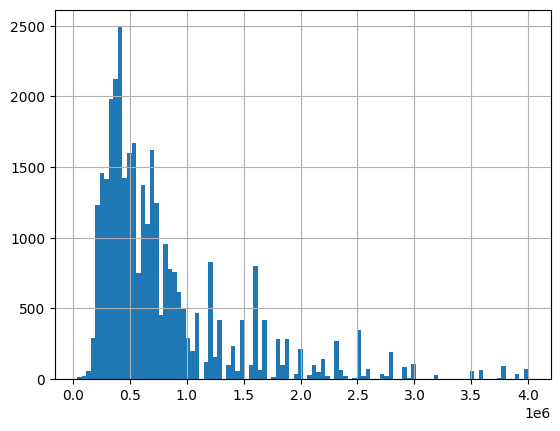

In [113]:
casas["price"].clip(0, 4_000_000).hist(bins=100)

In [77]:
data["infered_type"].unique()

array(['apartamento', 'casa', 'terreno', 'outro', 'cobertura', 'sobrados',
       'studio', 'flat', 'loja', 'quitinete', 'galpao', 'fazenda',
       'conjunto', 'chacara'], dtype=object)

0         apartamento
1                casa
2                casa
3                casa
4         apartamento
             ...     
103299          outro
103300           casa
103301           casa
103302          outro
103303           casa
Name: infered_type, Length: 102373, dtype: object

In [69]:

INFERED_TYPES

['apartamento',
 'casa',
 'terreno',
 'fazenda',
 'loja',
 'sobrados',
 'galpao',
 'conjunto',
 'cobertura',
 'studio',
 'flat',
 'quitinete',
 'chacara']

Index(['apartamento', 'casa', 'terreno', 'fazenda', 'loja', 'sobrados',
       'galpao', 'conjunto', 'cobertura', 'studio', 'flat', 'quitinete',
       'hotel', 'predio', 'centro', 'bianucci', '6', 'estancia', 'residencial',
       'bortolan', 'loft', 'loteamento', '1', 'parque', '3', 'chacara', 'joao',
       'zona', 'com', 'vila', 'campo', 'jardins', 'area', 'jardim'],
      dtype='object', name='link')

In [25]:
data["link"].str[:5].unique()

array(['/imov', None, '/lanc'], dtype=object)

In [18]:
data["link"].str[:30]

0         https://www.zapimoveis.com.br/
1         https://www.zapimoveis.com.br/
2         https://www.zapimoveis.com.br/
3         https://www.zapimoveis.com.br/
4         https://www.zapimoveis.com.br/
                       ...              
103299                              None
103300    https://www.zapimoveis.com.br/
103301    https://www.zapimoveis.com.br/
103302                              None
103303    https://www.zapimoveis.com.br/
Name: link, Length: 103164, dtype: object

# Data Splitting

In [97]:
AVOID = [
    "venda-loja",
    "venda-terreno",
    "venda-fazenda",
]

In [100]:
data[~data["link"].str.contains("venda-casa").fillna(False)].sample().iloc[0]["link"]

/tmp/ipykernel_186/2606236399.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[~data["link"].str.contains("venda-casa").fillna(False)].sample().iloc[0]["link"]


'https://www.zapimoveis.com.br/imovel/venda-sobrados-3-quartos-residencial-belvedere-pocos-de-caldas-100m2-id-2745580700/'

In [74]:
data.sample().iloc[0]["link"]

'https://www.zapimoveis.com.br/imovel/venda-casa-de-condominio-3-quartos-residencial-morumbi-pocos-de-caldas-119m2-id-2717881338/'

In [60]:
data_train[data_train["price"] > 50_000_000].iloc[0]["link"]

'https://www.zapimoveis.com.br/imovel/venda-fazenda-sitio-chacara-6-quartos-com-churrasqueira-area-rural-de-pocos-de-caldas-pocos-de-caldas-9490000m2-id-2688525934/'

<Axes: >

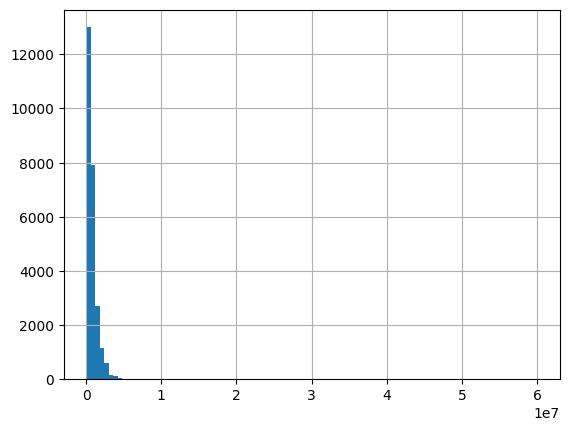

In [51]:
data_train["price"].hist(bins=100)

In [16]:
data.shape

(32039, 23)

,id,estate_id,action,search_date,post_type,link,type,image_list,snippet,street,...,latitude,longitude,floor_size,number_of_rooms,number_of_bathrooms,number_of_parking_spaces,amenities_list,price,condominium,iptu
0,ff0af6b2-ef1b-4070-ae2f-0a6312c47157,2753629515,venda,2024-11-27 05:21:57.499350,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 4 quartos à venda,,...,-21.826302,-46.557761,219.0,4.0,4.0,3.0,None,450000.00,NaN,NaN
1,02007133-c21e-4dc9-9e2f-34e9d95e92d6,2756849948,venda,2024-11-27 05:21:57.499350,SUPER PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 3 quartos à venda,,...,-21.793090,-46.601182,131.0,3.0,4.0,3.0,"[Circuito de segurança, Portaria 24h, Espaço g...",820000.00,NaN,NaN
2,476271bb-6912-4e8f-acdb-f9389ab87124,2635633461,venda,2024-11-27 05:21:57.499350,PREMIUM,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com quarto à venda,,...,-21.802998,-46.543752,63.0,1.0,1.0,NaN,None,250000.00,NaN,NaN
3,54e2c195-c656-4b6f-9ab1-cdf7fbc35298,2568096547,venda,2024-11-27 05:21:57.499350,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 3 quartos à venda,,...,-21.804587,-46.542271,234.0,3.0,1.0,2.0,"[Churrasqueira, Cozinha, Quintal]",950000.00,0.00,1.00
4,9d55c66b-455b-447b-a0f9-fb02328a9810,2673458096,venda,2024-11-27 05:21:57.499350,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,Casa com 2 quartos à venda,,...,-21.810266,-46.500426,80.0,2.0,1.0,1.0,"[Cozinha, Área de serviço, Quintal]",270000.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32034,5cbfee92-08de-4cb6-9c20-8451155a7caf,2747437002,venda,2024-12-04 21:33:26.187772,STANDARD,https://www.zapimoveis.com.br/imovel/venda-sob...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim dos Estados, Poços de Caldas",None,...,-21.783975,-46.552999,470.0,4.0,3.0,4.0,None,2100000.00,NaN,NaN
32035,05d7e131-825d-48a5-9661-2f0e842c83b4,3cbde387-7,venda,2024-12-04 21:33:26.187772,None,None,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Santa Ângela, Poços de Caldas",None,...,-21.797690,-46.569308,322.0,3.0,3.0,0.0,None,1350000.00,NaN,NaN
32036,6b93327e-a5d5-42b8-80a5-38a3dab42deb,2489430987,venda,2024-12-04 21:33:26.187772,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim Del Rey, Poços de Caldas",None,...,-21.798679,-46.559422,383.0,4.0,4.0,6.0,None,2900000.00,NaN,NaN
32037,464a3b36-f320-49b9-8d80-a6d026f5b356,2638082333,venda,2024-12-04 21:33:26.187772,STANDARD,https://www.zapimoveis.com.br/imovel/venda-cas...,Casa,[https://resizedimgs.zapimoveis.com.br/crop/61...,"Jardim Europa, Poços de Caldas",None,...,-21.800563,-46.589036,330.0,3.0,4.0,2.0,None,1900000.00,NaN,NaN
